<i>Copyright (c) Recommenders contributors.</i>

<i>Licensed under the MIT License.</i>

# NPA: Neural News Recommendation with Personalized Attention
NPA \[1\] is a news recommendation model with personalized attention. The core of NPA is a news representation model and a user representation model. In the news representation model we use a CNN network to learn hidden representations of news articles based on their titles. In the user representation model we learn the representations of users based on the representations of their clicked news articles. In addition, a word-level and a news-level personalized attention are used to capture different informativeness for different users.

## Properties of NPA:
- NPA is a content-based news recommendation method.
- It uses a CNN network to learn news representation. And it learns user representations from their clicked news articles.
- A word-level personalized attention is used to help NPA attend to important words for different users.
- A news-level personalized attention is used to help NPA attend to important historical clicked news for different users.

## Data format:
For quicker training and evaluaiton, we sample MINDdemo dataset of 5k users from [MIND small dataset](https://msnews.github.io/). The MINDdemo dataset has the same file format as MINDsmall and MINDlarge. If you want to try experiments on MINDsmall
 and MINDlarge, please change the dowload source.
 Select the MIND_type parameter from ['large', 'small', 'demo'] to choose dataset.
 
**MINDdemo_train** is used for training, and **MINDdemo_dev** is used for evaluation. Training data and evaluation data are composed of a news file and a behaviors file. You can find more detailed data description in [MIND repo](https://github.com/msnews/msnews.github.io/blob/master/assets/doc/introduction.md)

### news data
This file contains news information including newsid, category, subcatgory, news title, news abstarct, news url and entities in news title, entities in news abstarct.
One simple example: <br>

`N46466	lifestyle	lifestyleroyals	The Brands Queen Elizabeth, Prince Charles, and Prince Philip Swear By	Shop the notebooks, jackets, and more that the royals can't live without.	https://www.msn.com/en-us/lifestyle/lifestyleroyals/the-brands-queen-elizabeth,-prince-charles,-and-prince-philip-swear-by/ss-AAGH0ET?ocid=chopendata	[{"Label": "Prince Philip, Duke of Edinburgh", "Type": "P", "WikidataId": "Q80976", "Confidence": 1.0, "OccurrenceOffsets": [48], "SurfaceForms": ["Prince Philip"]}, {"Label": "Charles, Prince of Wales", "Type": "P", "WikidataId": "Q43274", "Confidence": 1.0, "OccurrenceOffsets": [28], "SurfaceForms": ["Prince Charles"]}, {"Label": "Elizabeth II", "Type": "P", "WikidataId": "Q9682", "Confidence": 0.97, "OccurrenceOffsets": [11], "SurfaceForms": ["Queen Elizabeth"]}]	[]`
<br>

In general, each line in data file represents information of one piece of news: <br>

`[News ID] [Category] [Subcategory] [News Title] [News Abstrct] [News Url] [Entities in News Title] [Entities in News Abstract] ...`

<br>

We generate a word_dict file to tranform words in news title to word indexes, and a embedding matrix is initted from pretrained glove embeddings.

### behaviors data
One simple example: <br>
`1	U82271	11/11/2019 3:28:58 PM	N3130 N11621 N12917 N4574 N12140 N9748	N13390-0 N7180-0 N20785-0 N6937-0 N15776-0 N25810-0 N20820-0 N6885-0 N27294-0 N18835-0 N16945-0 N7410-0 N23967-0 N22679-0 N20532-0 N26651-0 N22078-0 N4098-0 N16473-0 N13841-0 N15660-0 N25787-0 N2315-0 N1615-0 N9087-0 N23880-0 N3600-0 N24479-0 N22882-0 N26308-0 N13594-0 N2220-0 N28356-0 N17083-0 N21415-0 N18671-0 N9440-0 N17759-0 N10861-0 N21830-0 N8064-0 N5675-0 N15037-0 N26154-0 N15368-1 N481-0 N3256-0 N20663-0 N23940-0 N7654-0 N10729-0 N7090-0 N23596-0 N15901-0 N16348-0 N13645-0 N8124-0 N20094-0 N27774-0 N23011-0 N14832-0 N15971-0 N27729-0 N2167-0 N11186-0 N18390-0 N21328-0 N10992-0 N20122-0 N1958-0 N2004-0 N26156-0 N17632-0 N26146-0 N17322-0 N18403-0 N17397-0 N18215-0 N14475-0 N9781-0 N17958-0 N3370-0 N1127-0 N15525-0 N12657-0 N10537-0 N18224-0`
<br>

In general, each line in data file represents one instance of an impression. The format is like: <br>

`[Impression ID] [User ID] [Impression Time] [User Click History] [Impression News]`

<br>

User Click History is the user historical clicked news before Impression Time. Impression News is the displayed news in an impression, which format is:<br>

`[News ID 1]-[label1] ... [News ID n]-[labeln]`

<br>
Label represents whether the news is clicked by the user. All information of news in User Click History and Impression News can be found in news data file.

## Global settings and imports

In [19]:
import tensorflow.keras

In [20]:
import sys
import os
import numpy as np
import zipfile
from tqdm import tqdm
import scrapbook as sb
from tempfile import TemporaryDirectory
import tensorflow as tf
# tf.get_logger().setLevel('ERROR') # only show error messages

from recommenders.models.deeprec.deeprec_utils import download_deeprec_resources 
from recommenders.models.newsrec.newsrec_utils import prepare_hparams
from recommenders.models.newsrec.models.npa import NPAModel
from recommenders.models.newsrec.io.mind_iterator import MINDIterator
from recommenders.models.newsrec.newsrec_utils import get_mind_data_set

print("System version: {}".format(sys.version))
print("Tensorflow version: {}".format(tf.__version__))

System version: 3.9.12 (main, Jun  1 2022, 11:38:51) 
[GCC 7.5.0]
Tensorflow version: 2.15.0


## Prepare Parameters

In [21]:
epochs = 5
seed = 42
batch_size = 32

# Options: demo, small, large
MIND_type = 'demo'

## Download and load data

In [22]:
tmpdir = TemporaryDirectory()
data_path = tmpdir.name

train_news_file = os.path.join(data_path, 'train', r'news.tsv')
train_behaviors_file = os.path.join(data_path, 'train', r'behaviors.tsv')
valid_news_file = os.path.join(data_path, 'valid', r'news.tsv')
valid_behaviors_file = os.path.join(data_path, 'valid', r'behaviors.tsv')
wordEmb_file = os.path.join(data_path, "utils", "embedding.npy")
userDict_file = os.path.join(data_path, "utils", "uid2index.pkl")
wordDict_file = os.path.join(data_path, "utils", "word_dict.pkl")
yaml_file = os.path.join(data_path, "utils", r'npa.yaml')

mind_url, mind_train_dataset, mind_dev_dataset, mind_utils = get_mind_data_set(MIND_type)

if not os.path.exists(train_news_file):
    download_deeprec_resources(mind_url, os.path.join(data_path, 'train'), mind_train_dataset)
    
if not os.path.exists(valid_news_file):
    download_deeprec_resources(mind_url, \
                               os.path.join(data_path, 'valid'), mind_dev_dataset)
if not os.path.exists(yaml_file):
    download_deeprec_resources(r'https://recodatasets.z20.web.core.windows.net/newsrec/', \
                               os.path.join(data_path, 'utils'), mind_utils)

100%|██████████| 17.0k/17.0k [00:00<00:00, 42.0kKB/s]
100%|██████████| 9.84k/9.84k [00:00<00:00, 27.3kKB/s]
100%|██████████| 95.0k/95.0k [00:01<00:00, 74.4kKB/s]


# Examine News Data

## Examine categories

In [23]:
import pandas as pd
# This file contains news information including newsid, category, subcategory, 
# news title, news abstarct, news url and entities in news title, entities in news abstract.

columns = ['newsid', 'category', 'subcategory', 'news title', 'news abstract', 'news url', 'entities in news title', 'entities in news abstract']

# Load the TSV file with specified column names
df = pd.read_csv(train_news_file, delimiter='\t', names=columns)
df.head()

,newsid,category,subcategory,news title,news abstract,news url,entities in news title,entities in news abstract
0,N3112,lifestyle,lifestyleroyals,"The Brands Queen Elizabeth, Prince Charles, an...","Shop the notebooks, jackets, and more that the...",https://www.msn.com/en-us/lifestyle/lifestyler...,"[{""Label"": ""Prince Philip, Duke of Edinburgh"",...",[]
1,N10399,news,newsworld,The Cost of Trump's Aid Freeze in the Trenches...,Lt. Ivan Molchanets peeked over a parapet of s...,https://www.msn.com/en-us/news/world/the-cost-...,[],"[{""Label"": ""Ukraine"", ""Type"": ""G"", ""WikidataId..."
2,N12103,health,voices,I Was An NBA Wife. Here's How It Affected My M...,"I felt like I was a fraud, and being an NBA wi...",https://www.msn.com/en-us/health/voices/i-was-...,[],"[{""Label"": ""National Basketball Association"", ..."
3,N20460,health,medical,"How to Get Rid of Skin Tags, According to a De...","They seem harmless, but there's a very good re...",https://www.msn.com/en-us/health/medical/how-t...,"[{""Label"": ""Skin tag"", ""Type"": ""C"", ""WikidataI...","[{""Label"": ""Skin tag"", ""Type"": ""C"", ""WikidataI..."
4,N5409,weather,weathertopstories,It's been Orlando's hottest October ever so fa...,There won't be a chill down to your bones this...,https://www.msn.com/en-us/weather/weathertopst...,"[{""Label"": ""Orlando, Florida"", ""Type"": ""G"", ""W...","[{""Label"": ""Orlando, Florida"", ""Type"": ""G"", ""W..."


In [24]:
category_distribution = df['category'].value_counts()

category_distribution

news             8498
sports           6301
finance          1766
lifestyle        1511
foodanddrink     1474
travel           1229
health           1178
weather           968
video             933
autos             894
tv                670
music             496
movies            412
entertainment     399
kids                8
middleeast          2
northamerica        1
Name: category, dtype: int64

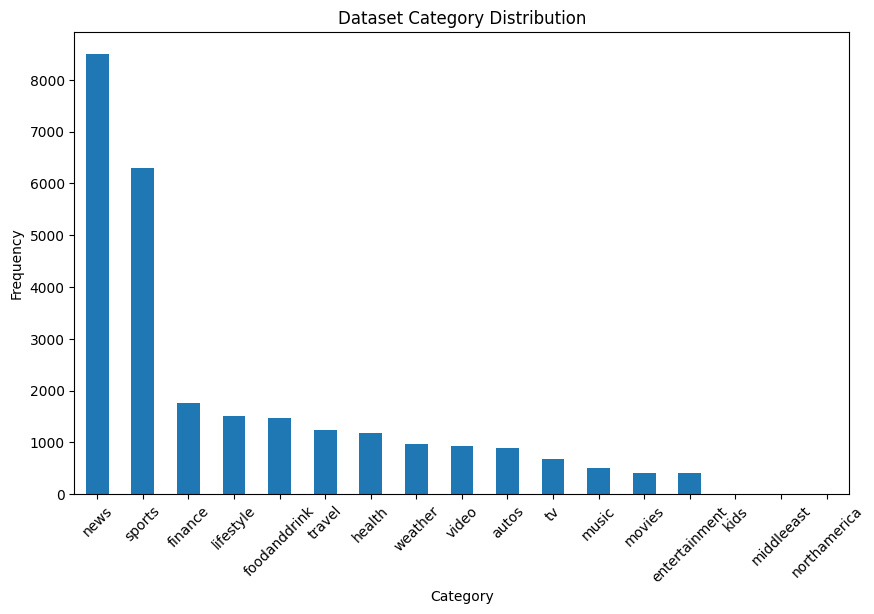

In [26]:
import matplotlib.pyplot as plt

# Count the number of occurrences of each category
category_distribution = df['category'].value_counts()

# Plotting the distribution as a bar graph
plt.figure(figsize=(10, 6))  # Adjust the size as needed
category_distribution.plot(kind='bar')
plt.title('Dataset Category Distribution')
plt.xlabel('Category')
plt.ylabel('Frequency')
plt.xticks(rotation=45)  # Rotates the category names for better readability
plt.savefig('figures/baseline_dataset/category_distribution.png', bbox_inches='tight')

plt.show()

## Visualize subcategories

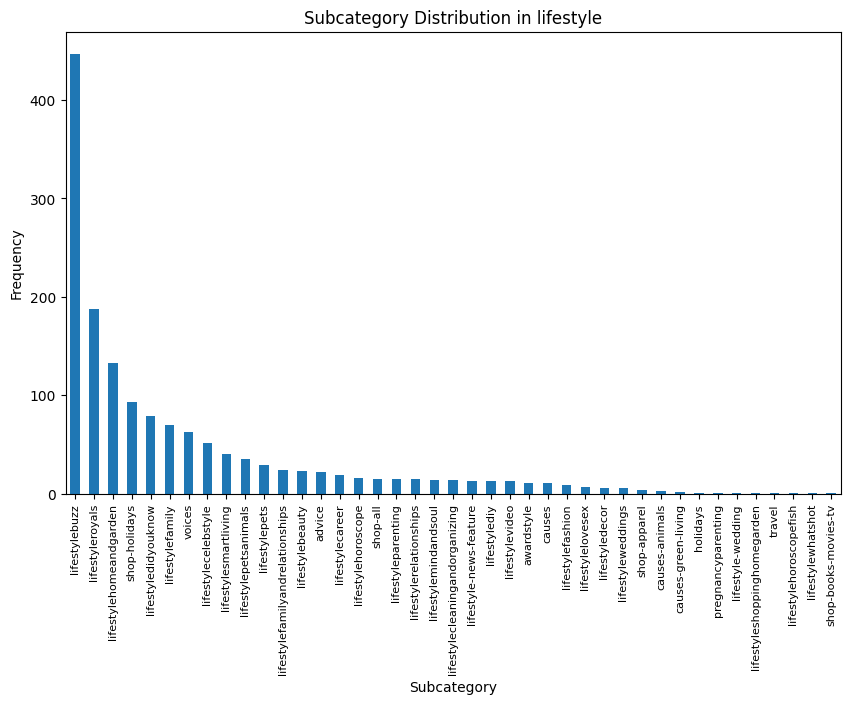

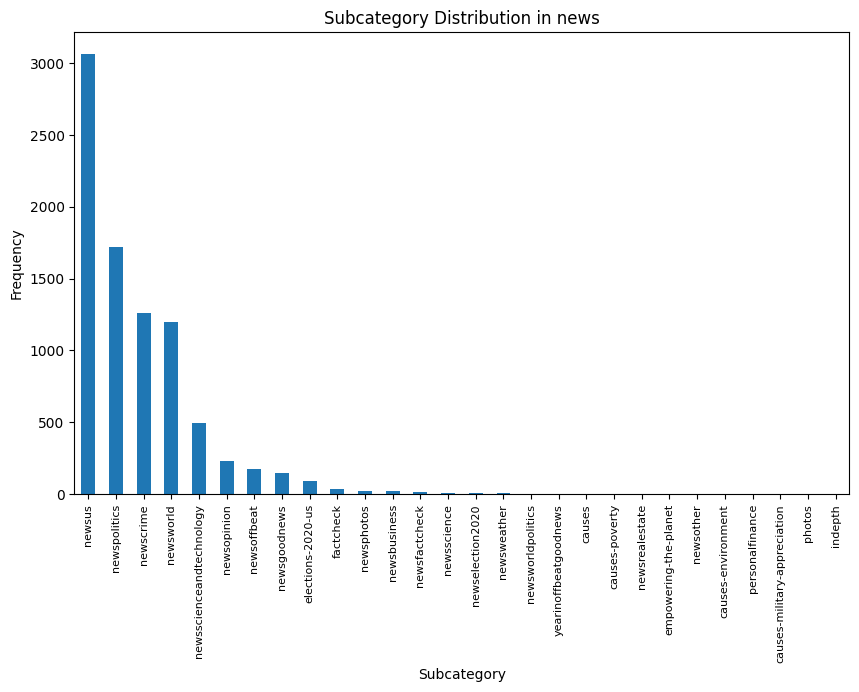

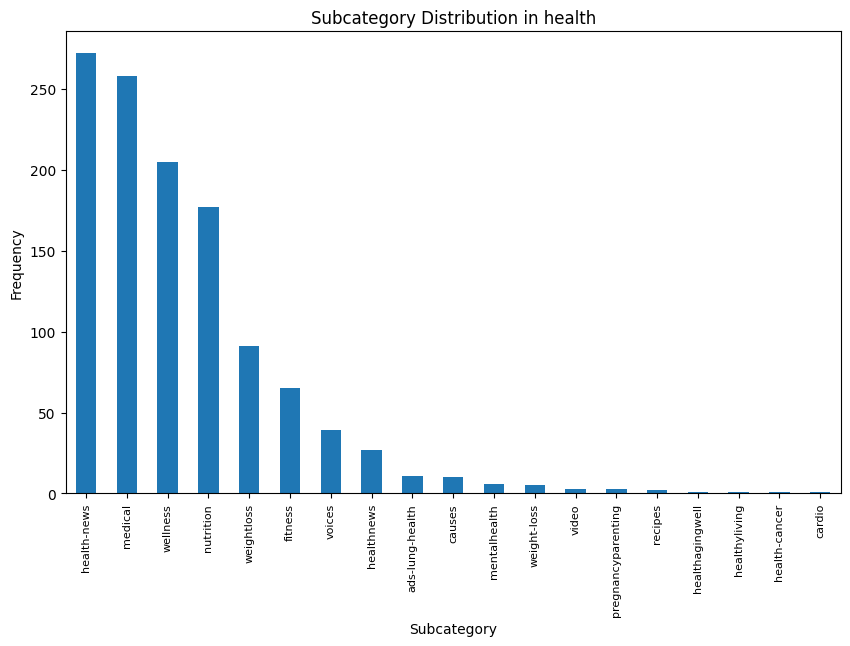

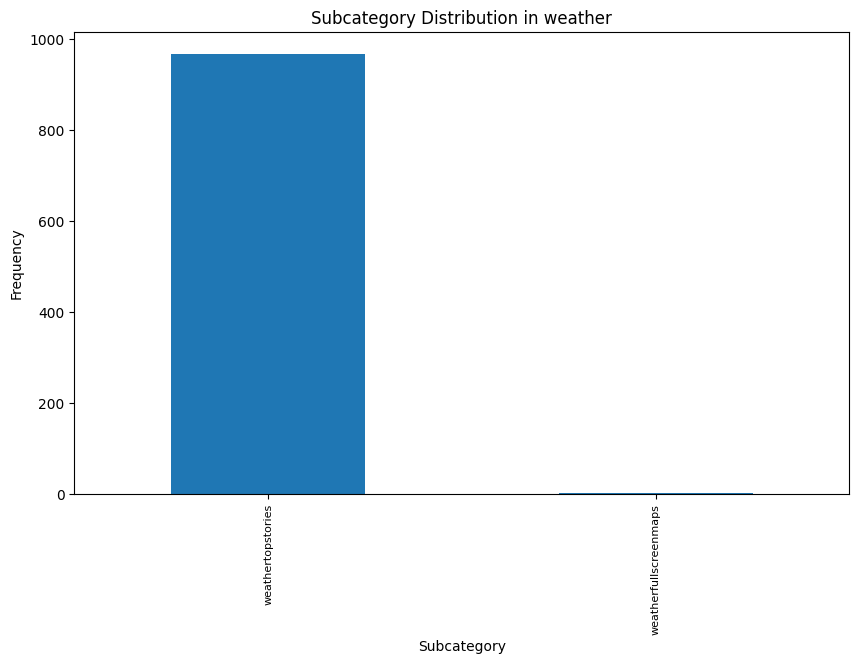

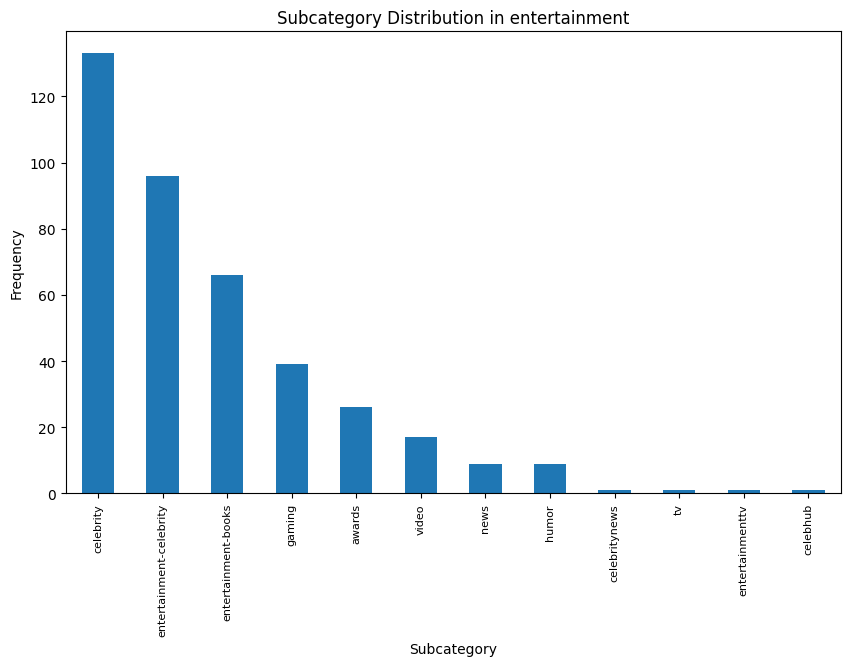

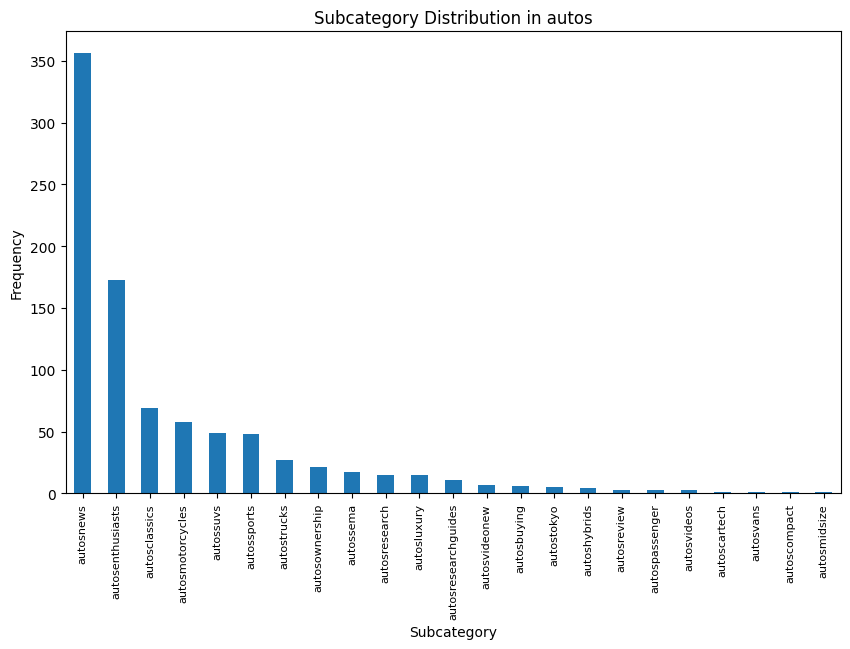

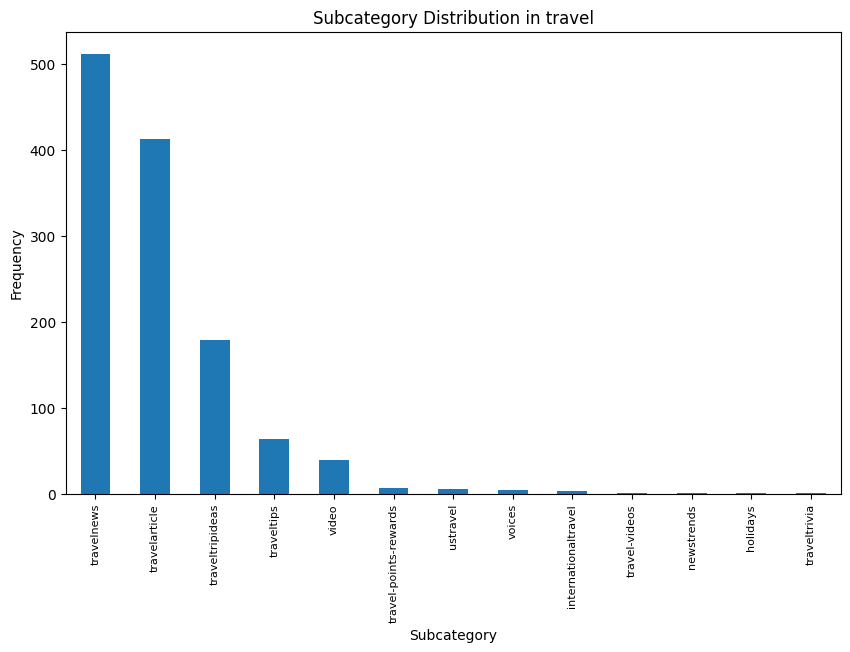

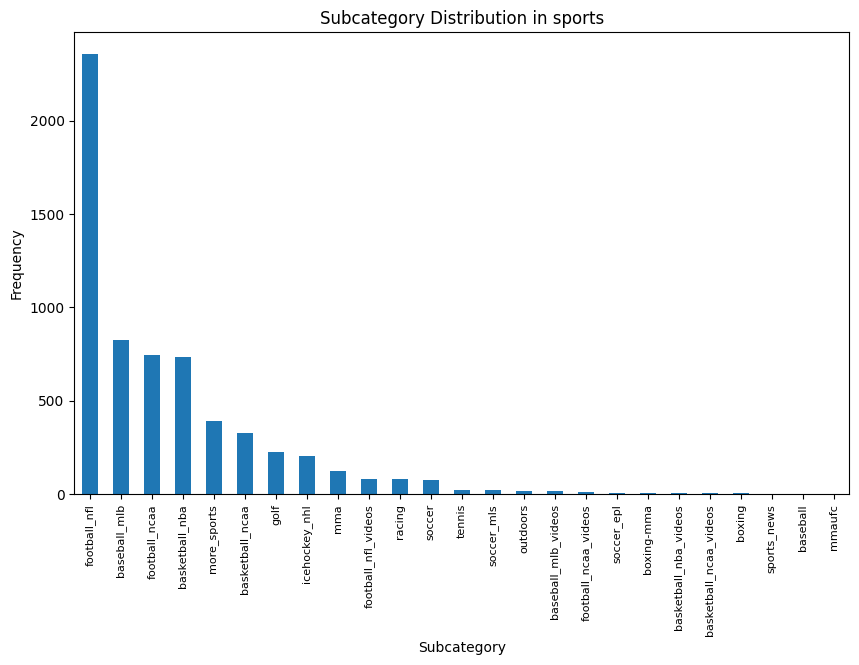

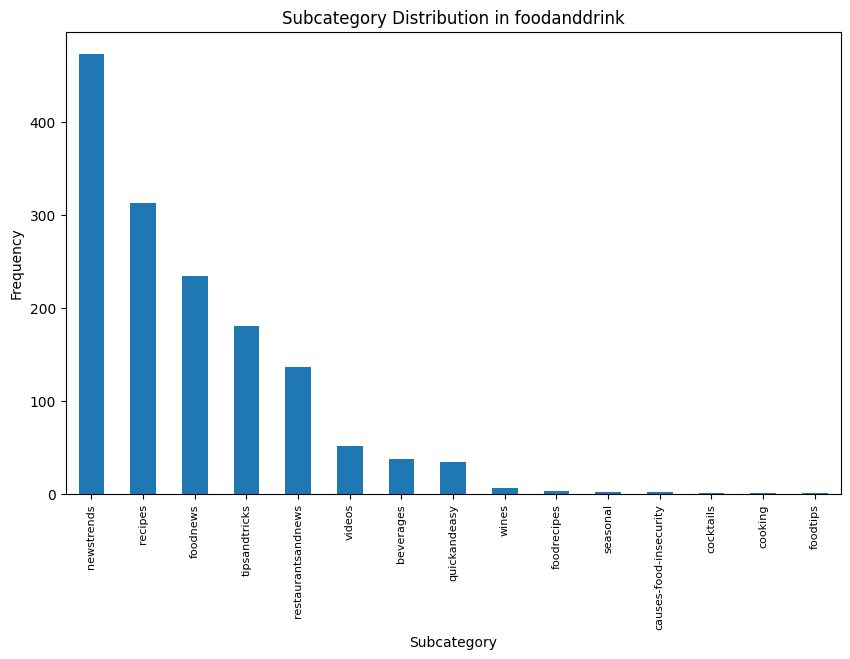

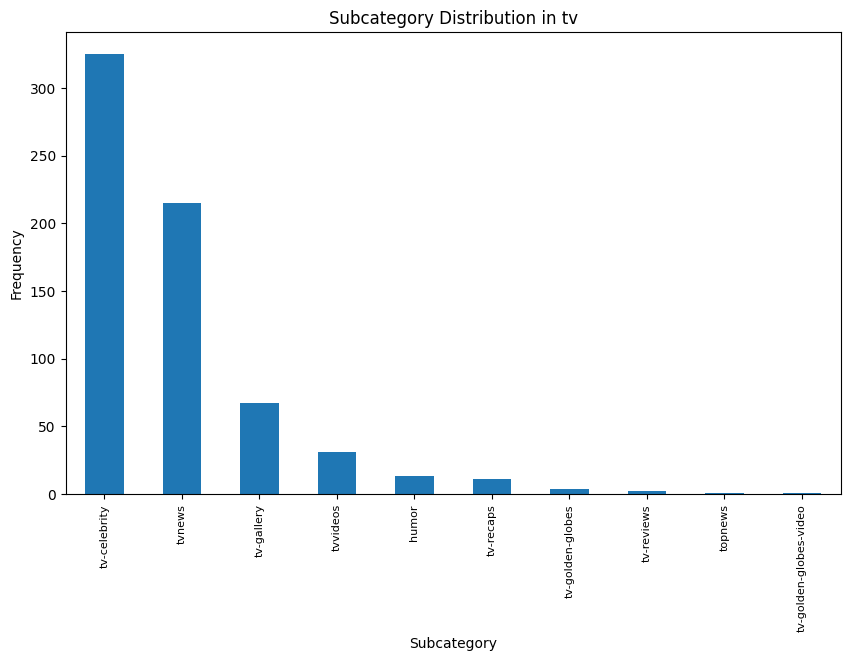

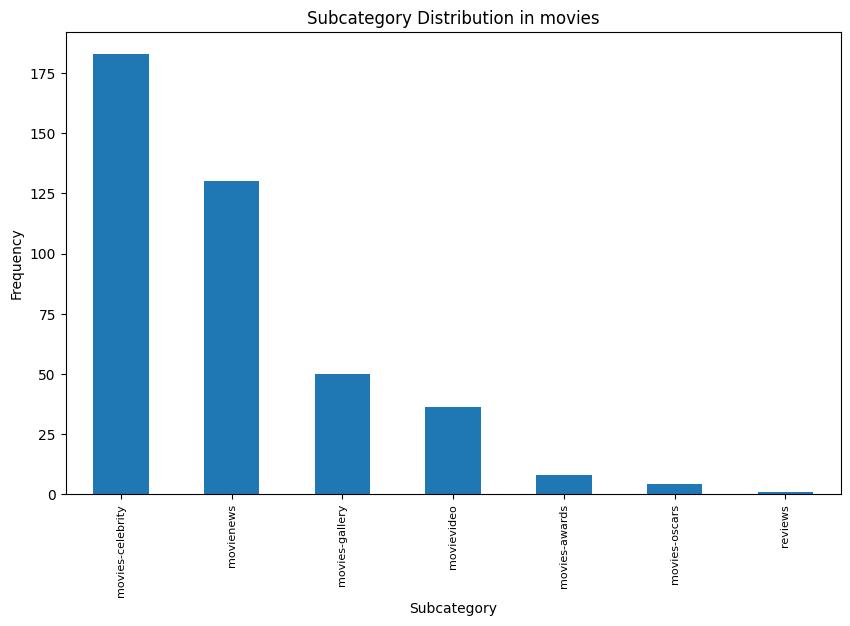

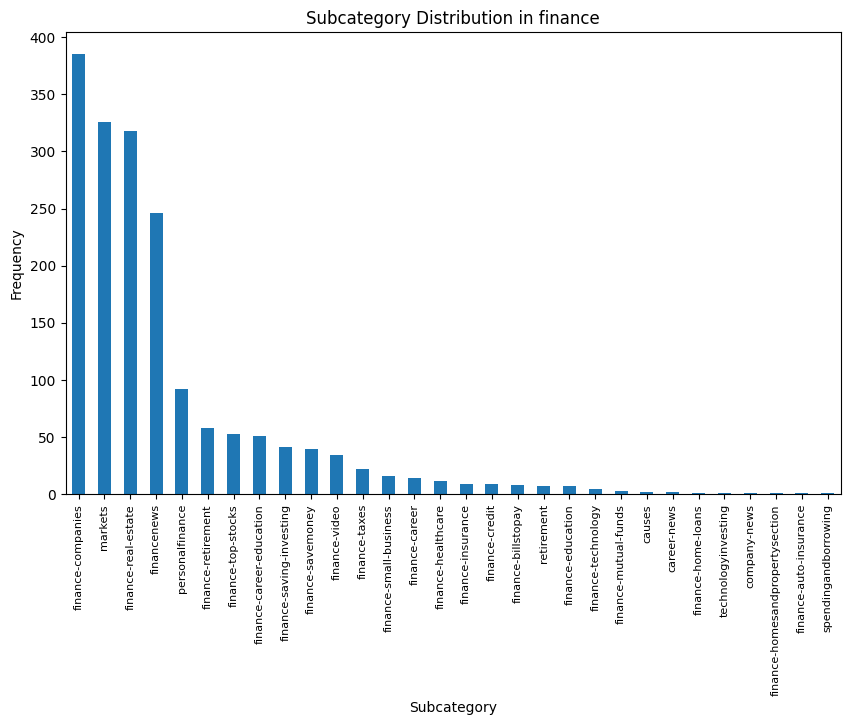

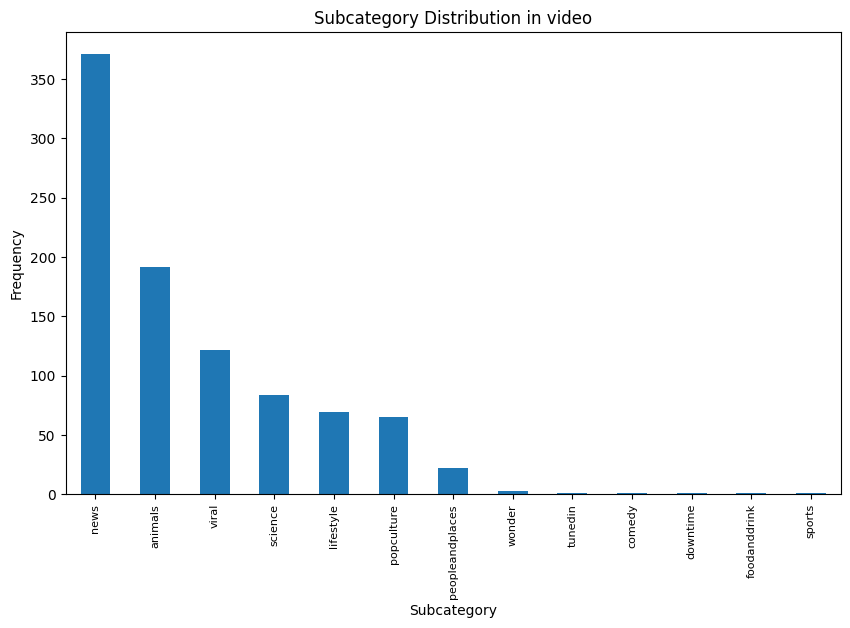

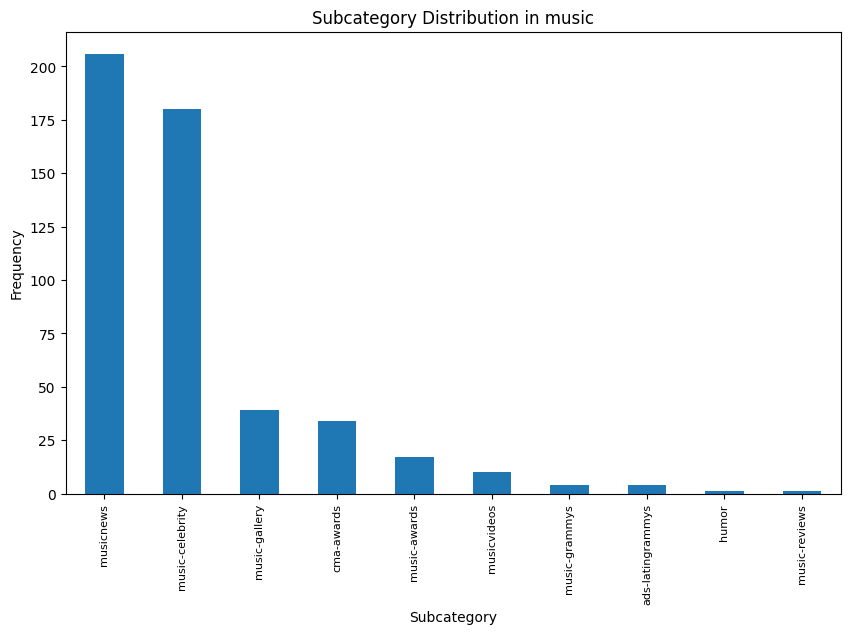

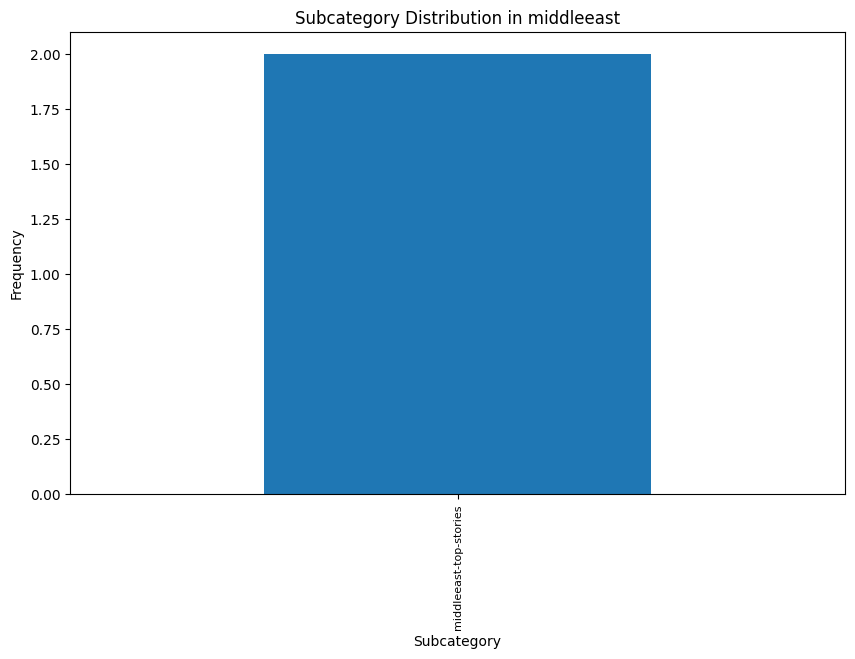

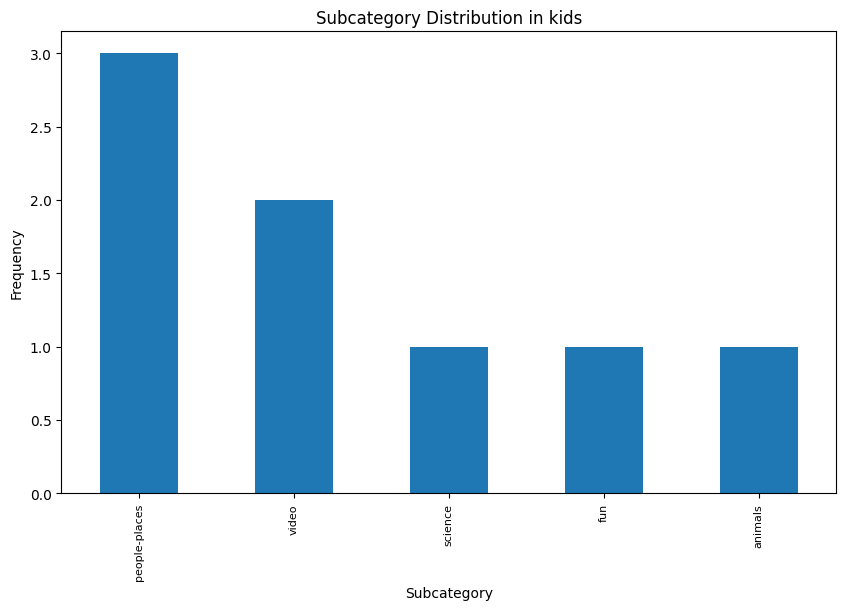

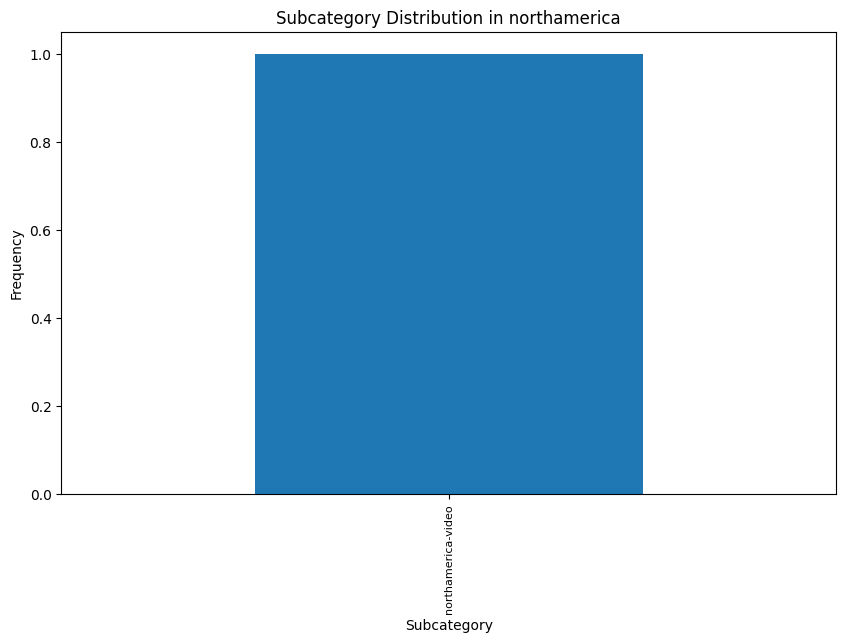

In [27]:
# Get unique categories
categories = df['category'].unique()

# Create a plot for each category
for category in categories:
    # Filter data for the current category
    category_data = df[df['category'] == category]
    
    # Count the occurrences of each subcategory within this category
    subcategory_counts = category_data['subcategory'].value_counts()

    # Plotting
    plt.figure(figsize=(10, 6))
    subcategory_counts.plot(kind='bar')
    plt.title(f'Subcategory Distribution in {category}')
    plt.xlabel('Subcategory')
    plt.ylabel('Frequency')
    plt.xticks(rotation=90, fontsize=8)
    plt.savefig(f'figures/baseline_dataset/subcategory_{category}.png', bbox_inches='tight')

    plt.show()

## Entity analysis

In [9]:
df

,newsid,category,subcategory,news title,news abstract,news url,entities in news title,entities in news abstract
0,N3112,lifestyle,lifestyleroyals,"The Brands Queen Elizabeth, Prince Charles, an...","Shop the notebooks, jackets, and more that the...",https://www.msn.com/en-us/lifestyle/lifestyler...,"[{""Label"": ""Prince Philip, Duke of Edinburgh"",...",[]
1,N10399,news,newsworld,The Cost of Trump's Aid Freeze in the Trenches...,Lt. Ivan Molchanets peeked over a parapet of s...,https://www.msn.com/en-us/news/world/the-cost-...,[],"[{""Label"": ""Ukraine"", ""Type"": ""G"", ""WikidataId..."
2,N12103,health,voices,I Was An NBA Wife. Here's How It Affected My M...,"I felt like I was a fraud, and being an NBA wi...",https://www.msn.com/en-us/health/voices/i-was-...,[],"[{""Label"": ""National Basketball Association"", ..."
3,N20460,health,medical,"How to Get Rid of Skin Tags, According to a De...","They seem harmless, but there's a very good re...",https://www.msn.com/en-us/health/medical/how-t...,"[{""Label"": ""Skin tag"", ""Type"": ""C"", ""WikidataI...","[{""Label"": ""Skin tag"", ""Type"": ""C"", ""WikidataI..."
4,N5409,weather,weathertopstories,It's been Orlando's hottest October ever so fa...,There won't be a chill down to your bones this...,https://www.msn.com/en-us/weather/weathertopst...,"[{""Label"": ""Orlando, Florida"", ""Type"": ""G"", ""W...","[{""Label"": ""Orlando, Florida"", ""Type"": ""G"", ""W..."
...,...,...,...,...,...,...,...,...
26735,N4833,news,newsscienceandtechnology,Realme takes chunk of India mobile market as S...,Over 400 percent more phones shipped year-on-year,https://www.msn.com/en-us/news/newsscienceandt...,"[{""Label"": ""Realme"", ""Type"": ""N"", ""WikidataId""...",[]
26736,N22331,sports,golf,Young Northeast Florida fans flock to U.S. wom...,When the U.S. women's national soccer team arr...,https://www.msn.com/en-us/sports/golf/young-no...,"[{""Label"": ""First Coast"", ""Type"": ""G"", ""Wikida...","[{""Label"": ""United States women's national soc..."
26737,N21897,weather,weathertopstories,"Adapting, Learning And Soul Searching: Reflect...",Woolsey Fire Anniversary: A community is forev...,https://www.msn.com/en-us/weather/topstories/a...,"[{""Label"": ""Woolsey Fire"", ""Type"": ""N"", ""Wikid...","[{""Label"": ""Woolsey Fire"", ""Type"": ""N"", ""Wikid..."
26738,N6299,lifestyle,lifestylefamily,Family says 13-year-old Broadway star died fro...,NaN,https://www.msn.com/en-us/lifestyle/lifestylef...,"[{""Label"": ""Broadway theatre"", ""Type"": ""F"", ""W...",[]


In [10]:
import pandas as pd
import json

def parse_entities(entity_str):
    # Check if entity_str is a string
    if not isinstance(entity_str, str):
        return []  # Return an empty list if it's not a string

    try:
        return json.loads(entity_str.replace("'", '"'))  # Replace single quotes with double quotes for valid JSON
    except json.JSONDecodeError:
        return [] 
    
# Assuming the column with entities is named 'entities_in_news'
df['parsed_entities'] = df['entities in news title'].apply(parse_entities)

# Flatten the list of entities and create a new DataFrame
all_entities = pd.json_normalize(df.explode('parsed_entities')['parsed_entities'])


In [11]:
top_entities = all_entities['Label'].value_counts()
top_entities

Donald Trump                994
National Football League    295
United States               278
Houston Astros              208
California                  194
                           ... 
Ruins                         1
Biltmore Estate               1
Koenigsegg                    1
Eliud Kipchoge                1
Lester Holt                   1
Name: Label, Length: 8981, dtype: int64

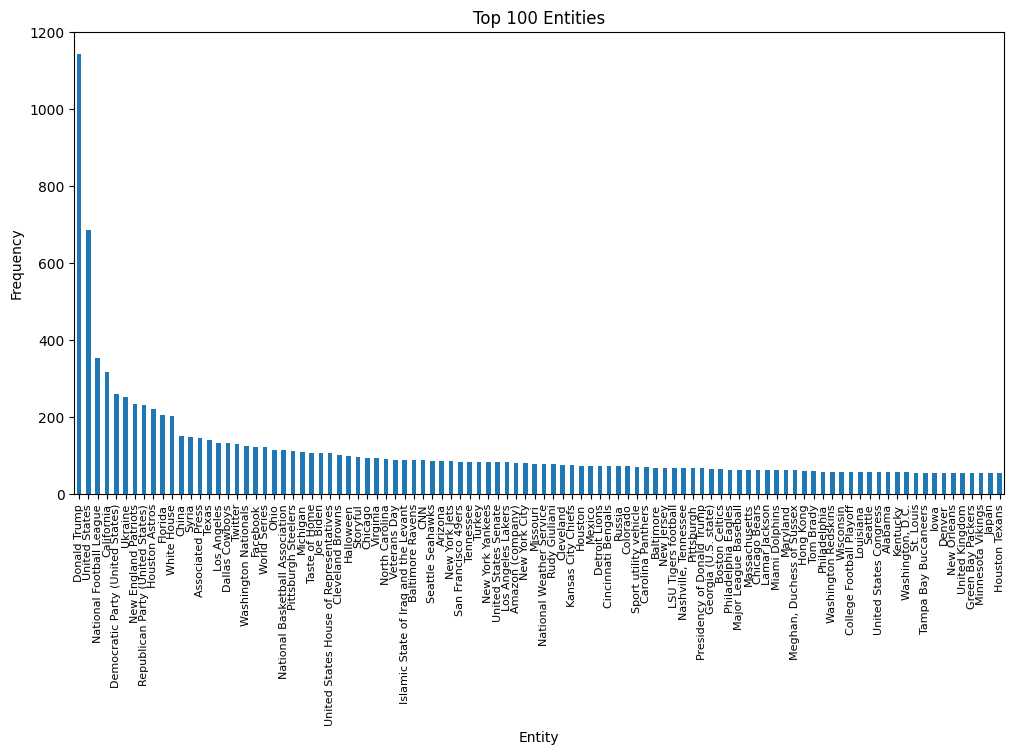

In [28]:
import matplotlib.pyplot as plt

# Count the occurrences of each entity
count = 100
top_entities = all_entities['Label'].value_counts().head(count)  # Adjust the number as needed

# Plot
plt.figure(figsize=(12, 6))
top_entities.plot(kind='bar')
plt.title(f'Top {count} Entities')
plt.xlabel('Entity')
plt.ylabel('Frequency')
plt.xticks(rotation=90, fontsize=8)
plt.savefig('figures/baseline_dataset/top_entities.png', bbox_inches='tight')

plt.show()


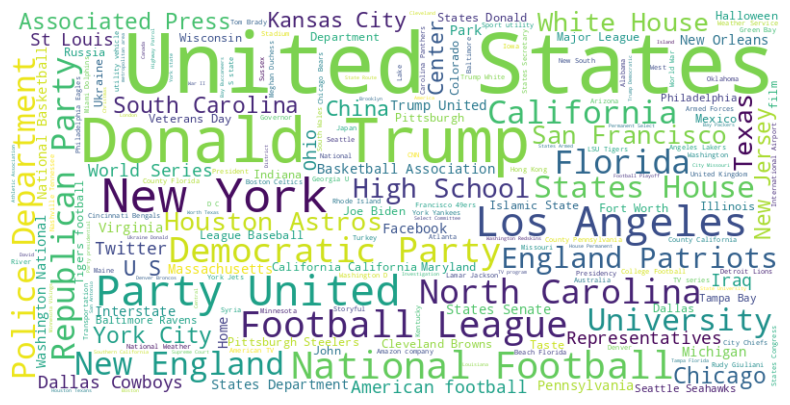

In [29]:
import wordcloud
from wordcloud import WordCloud

# Filter out non-string values and concatenate entity labels into a single string
entity_labels = ' '.join([str(label) for label in all_entities['Label'] if isinstance(label, str)])

# Generate a word cloud image
wordcloud = WordCloud(background_color='white', width=800, height=400).generate(entity_labels)

# Display the generated image
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.savefig('figures/baseline_dataset/top_entities_wordcloud.png', bbox_inches='tight')

plt.show()



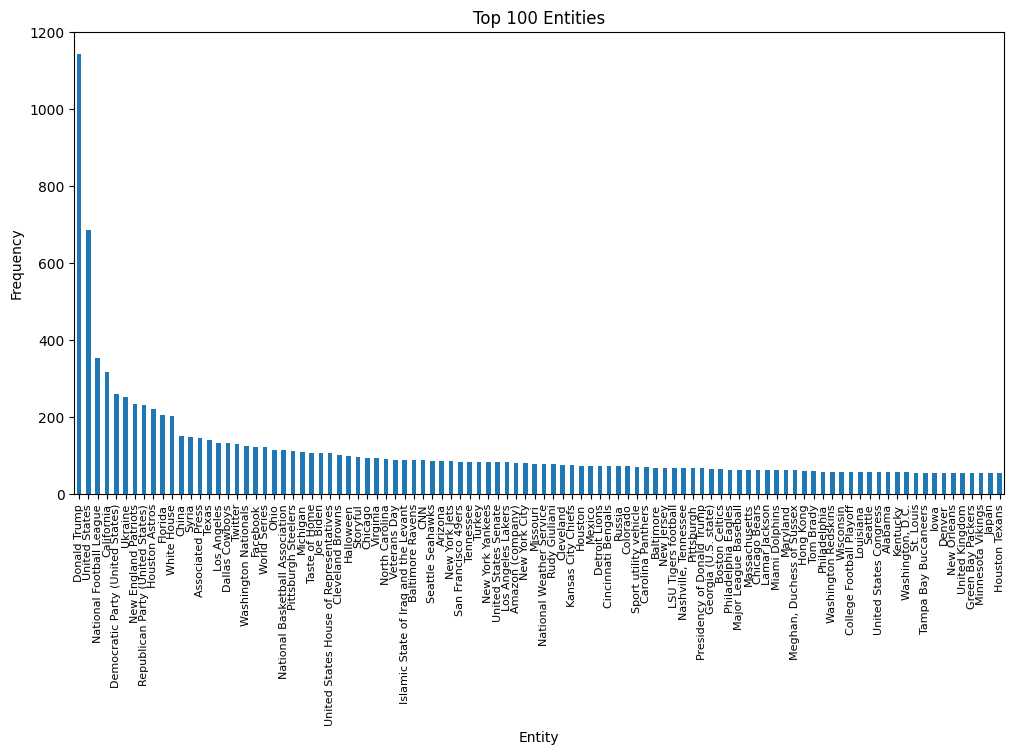

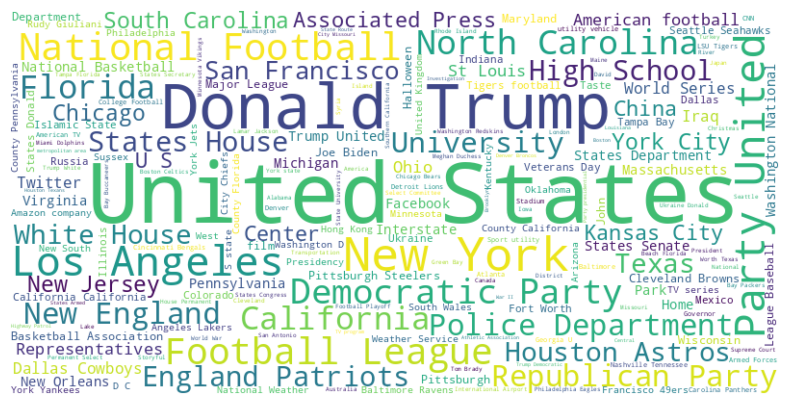

In [14]:
import pandas as pd
import json

def parse_entities(entity_str):
    # Check if entity_str is a string
    if not isinstance(entity_str, str):
        return []  # Return an empty list if it's not a string

    try:
        return json.loads(entity_str.replace("'", '"'))  # Replace single quotes with double quotes for valid JSON
    except json.JSONDecodeError:
        return [] 
    
# Assuming the column with entities is named 'entities_in_news'
df['parsed_entities_news'] = df['entities in news abstract'].apply(parse_entities)

# Flatten the list of entities and create a new DataFrame
all_entities = pd.json_normalize(df.explode('parsed_entities_news')['parsed_entities_news'])

# Count the occurrences of each entity
count = 100
top_entities = all_entities['Label'].value_counts().head(count)  # Adjust the number as needed

# Plot
plt.figure(figsize=(12, 6))
top_entities.plot(kind='bar')
plt.title(f'Top {count} Entities')
plt.xlabel('Entity')
plt.ylabel('Frequency')
plt.xticks(rotation=90, fontsize=8)
plt.show()


# Filter out non-string values and concatenate entity labels into a single string
entity_labels = ' '.join([str(label) for label in all_entities['Label'] if isinstance(label, str)])

# Generate a word cloud image
wordcloud = WordCloud(background_color='white', width=800, height=400).generate(entity_labels)

# Display the generated image
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()



# Examine user data

In [15]:


# Define the column names
column_names = ['Impression ID', 'User ID', 'Impression Time', 'User Click History', 'Impression News']

# Assuming the file path is 'behaviors.tsv'
file_path = 'behaviors.tsv'

# Load the TSV file into a pandas DataFrame
df = pd.read_csv(valid_behaviors_file, delimiter='\t', names=column_names)

# Display the first few rows of the DataFrame
df.head()

,Impression ID,User ID,Impression Time,User Click History,Impression News
0,1,U41827,11/15/2019 2:41:03 PM,N15366 N12202 N27489 N19773 N21134 N18191 N686...,N23699-0 N21291-0 N1901-0 N27292-0 N17443-0 N1...
1,2,U61881,11/15/2019 10:31:42 AM,N16469 N4202 N4202 N21816 N12992 N24242 N7366 ...,N26916-0 N4641-0 N25522-0 N14893-0 N19035-0 N3...
2,3,U54180,11/15/2019 5:36:17 AM,N22427 N16386 N24242 N4385 N14672 N12242 N1852...,N13528-0 N27689-0 N10879-0 N11662-0 N14409-0 N...
3,4,U41164,11/15/2019 9:13:44 AM,N13065 N5748 N12658 N276 N7395 N16010 N13761 N...,N20150-0 N1807-1 N26916-0 N28138-0 N9576-0 N19...
4,5,U8588,11/15/2019 5:39:04 AM,N6629 N4958 N10917 N27079 N828,N21325-0 N5982-0 N19737-1 N9576-0 N20150-0 N25...


In [16]:
# Assuming 'news_category_df' is your DataFrame with news categories
# It should have columns like 'News ID' and 'Category'

# Merge the CTR data with the news category data


In [17]:
# Split the impression_news into individual news items and their click labels
news_clicks = df['Impression News'].str.split(' ').explode()
news_clicks = news_clicks.str.split('-', expand=True).rename(columns={0: 'News ID', 1: 'Clicked'})

# Convert the Clicked column to numeric
news_clicks['Clicked'] = pd.to_numeric(news_clicks['Clicked'])

# Calculate Click-Through Rate for each news item
ctr = news_clicks.groupby('News ID')['Clicked'].mean()
# Sort the CTR and select top N for visualization
top_ctr = ctr.sort_values(ascending=False) # Adjust N as needed

# Plot
plt.figure(figsize=(12, 6))
top_ctr.plot(kind='bar')
plt.title('Top 20 News Items by Click-Through Rate')
plt.xlabel('News ID')
plt.ylabel('CTR')
plt.xticks(rotation=45)
plt.show()


KeyboardInterrupt



In [ ]:
ctr_with_category = pd.merge(ctr.to_frame(name='CTR'), df, on='News ID')


In [ ]:
# Assuming 'impression_time' is a column in your DataFrame
df['impression_time'] = pd.to_datetime(df['Impression Time'])
df.set_index('impression_time').resample('H').size().plot() 

In [ ]:
# I think I want to see content breakdown of the user's history
# And then content breakdown of user's recommendations

## Create hyper-parameters

In [ ]:
hparams = prepare_hparams(yaml_file, 
                          wordEmb_file=wordEmb_file,
                          wordDict_file=wordDict_file, 
                          userDict_file=userDict_file,
                          batch_size=batch_size,
                          epochs=epochs)
print(hparams)

In [ ]:
iterator = MINDIterator

## Train the NPA model

In [ ]:
model = NPAModel(hparams, iterator, seed=seed)

In [ ]:
print(model.run_eval(valid_news_file, valid_behaviors_file))

In [ ]:
  %%time
model.fit(train_news_file, train_behaviors_file, valid_news_file, valid_behaviors_file)

In [ ]:
%%time
res_syn = model.run_eval(valid_news_file, valid_behaviors_file)
print(res_syn)

In [ ]:
sb.glue("res_syn", res_syn)

## Save the model

In [ ]:
new_path = '.'
model_path = os.path.join(new_path, "model")
os.makedirs(model_path, exist_ok=True)

model.model.save_weights(os.path.join(model_path, "npa_ckpt"))

## Output Predcition File
This code segment is used to generate the prediction.zip file, which is in the same format in [MIND Competition Submission Tutorial](https://competitions.codalab.org/competitions/24122#learn_the_details-submission-guidelines).

Please change the `MIND_type` parameter to `large` if you want to submit your prediction to [MIND Competition](https://msnews.github.io/competition.html).

In [ ]:
group_impr_indexes, group_labels, group_preds = model.run_slow_eval(valid_news_file, valid_behaviors_file)

In [ ]:
with open(os.path.join(new_path, 'prediction.txt'), 'w') as f:
    for impr_index, preds in tqdm(zip(group_impr_indexes, group_preds)):
        impr_index += 1
        pred_rank = (np.argsort(np.argsort(preds)[::-1]) + 1).tolist()
        pred_rank = '[' + ','.join([str(i) for i in pred_rank]) + ']'
        f.write(' '.join([str(impr_index), pred_rank])+ '\n')

In [ ]:
f = zipfile.ZipFile(os.path.join(new_path, 'prediction.zip'), 'w', zipfile.ZIP_DEFLATED)
f.write(os.path.join(data_path, 'prediction.txt'), arcname='prediction.txt')
f.close()

In [ ]:
df

In [ ]:
df_behaviors

In [ ]:
import pandas as pd

# Assuming you've already loaded the news data as df_news

# Specify columns for the behaviors data
behavior_columns = ['impression_id', 'user_id', 'impression_time', 'user_click_history', 'impression_news']


# Assuming you've already loaded the news data as df_news

# Load the behaviors data
# Replace 'train_behaviors_file' with the path to your behaviors data file
df_behaviors = pd.read_csv(valid_behaviors_file, delimiter='\t', names=behavior_columns)



In [ ]:
df_behaviors

In [ ]:
# import json

# # Sample impression data
# impressions = {
#     "24481": ["N125045", "N87192", "N73556", "N20417"]
#     # Add more impressions as needed
# }

# # Function to read and parse the prediction.txt file
# def parse_predictions(file_path):
#     predictions = {}
#     with open(file_path, 'r') as file:
#         for line in file:
#             parts = line.strip().split(' ')
#             impression_id = parts[0]
#             ranks = json.loads('[' + parts[1] + ']')
#             predictions[impression_id] = ranks
#     return predictions

# # Function to map rankings to news IDs
# def map_rankings_to_news(impressions, predictions):
#     mapped_results = {}
#     for impression_id, ranks in predictions.items():
#         news_order = [impressions[impression_id][rank - 1] for rank in ranks]
#         mapped_results[impression_id] = news_order
#     return mapped_results

# # Parse the prediction results
# predictions = parse_predictions('prediction.txt')

# # Map rankings to news IDs
# mapped_results = map_rankings_to_news(impressions, predictions)

# # Display the results
# for impression_id, news_order in mapped_results.items():
#     print(f"Impression {impression_id}: {news_order}")


In [ ]:
len(predictions)

In [ ]:
len(df_behaviors)

In [ ]:
len(df_behaviors.loc[33, 'impression_news'])

In [ ]:
df_behaviors

In [ ]:
group_impr_indexes

## Reference
\[1\] Chuhan Wu, Fangzhao Wu, Mingxiao An, Jianqiang Huang, Yongfeng Huang and Xing Xie: NPA: Neural News Recommendation with Personalized Attention, KDD 2019, ADS track.<br>
\[2\] Wu, Fangzhao, et al. "MIND: A Large-scale Dataset for News Recommendation" Proceedings of the 58th Annual Meeting of the Association for Computational Linguistics. https://msnews.github.io/competition.html <br>
\[3\] GloVe: Global Vectors for Word Representation. https://nlp.stanford.edu/projects/glove/